<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (You will be implementing the decoder, not the encoder, as we are not doing sequence-to-sequence translation.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [ ]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

import unidecode
import string
import random
import re
 
import pdb
 
all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print('file_len =', file_len)

--2021-10-16 19:50:57--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 52.44.149.188, 54.86.243.162, 52.54.75.23, ...
Connecting to piazza.com (piazza.com)|52.44.149.188|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2021-10-16 19:50:57--  https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving cdn-uploads.piazza.com (cdn-uploads.piazza.com)... 13.35.89.25, 13.35.89.70, 13.35.89.117, ...
Connecting to cdn-uploads.piazza.com (cdn-uploads.piazza.com)|13.35.89.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[===================>]   1.46M  --.-KB/s    in 0.

In [ ]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

 Lamedon; and the Shadow 
Host 

pressed behind and fear went on before them, until they came to Calembel 
upon Ciril, and the sun went down like blood behind Pinnath Gelin away in 
the West behind the


In [ ]:
import torch
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please do not look at the documentation's code for the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**
* Create a custom GRU cell

**DONE:**
* Create a custom GRU cell


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.num_layers = num_layers
    self.sig = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.W_ir = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(num_layers)])
    self.W_hr = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)])
    self.W_iz = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(num_layers)])
    self.W_hz = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)])
    self.W_in = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(num_layers)])
    self.W_hn = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)])
    
  
  def forward(self, inputs, hidden):
    # Each layer does the following:
    # r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
    # z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
    # n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
    # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
    # Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)
    for i in range(self.num_layers):
      r_t = self.sig(self.W_ir[i](inputs) + self.W_hr[i](hidden))
      z_t = self.sig(self.W_iz[i](inputs) + self.W_hz[i](hidden))
      n_t = self.tanh(self.W_in[i](inputs) + (r_t * self.W_hn[i](hidden)))
      h_t = ((1 - z_t) * n_t) + (z_t * (hidden))
    return n_t, h_t
  


---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**
* Create an RNN class that extends from nn.Module.

**DONE:**
* Create an RNN class that extends from nn.Module.


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers

    self.embedding= nn.Embedding(output_size, hidden_size)
    self.gru = GRU(hidden_size, hidden_size, num_layers=n_layers) 
    self.softmax = nn.LogSoftmax(dim=1)
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, input_char, hidden):
    # by reviewing the documentation, construct a forward function that properly uses the output
    # of the GRU
    #print('input_char: ', input_char)
    output = self.embedding(input_char).view(1, 1, -1)
    output = F.relu(output)
    #print('output size: ', output.size())
    #print('hidden size: ', hidden.size())
    out_decoded, hidden = self.gru(output, hidden)
    #print('gru out: ', out_decoded.size())
    out_decoded = self.softmax(self.out(out_decoded[0]))
    #print('out_dec after softmax size: ', out_decoded.size())
    return out_decoded, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

In [ ]:
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**
* Fill in the pieces.

**DONE:**
* Fill in the pieces.



In [ ]:
# NOTE: decoder_optimizer, decoder, and criterion will be defined below as global variables
def train(inp, target):
  ## initialize hidden layers, set up gradient and loss 
    # your code here
  ## /
  decoder_optimizer.zero_grad()
  hidden2 = decoder.init_hidden()
  loss = 0

  input_length = inp.size(0)
  target_length = target.size(0)
  #print('input_length: ', input_length)
  #print('target_length: ', target_length)
  
  decoder_outputs = torch.zeros(target_length, decoder.hidden_size)
  #print('here')
  for targ in range(target_length):
    #print('inp[input]: ', inp[input])
    #print('hidden: ', hidden.size())
    decoder_output, hidden2 = decoder(inp[targ], hidden2)
    #print('dec_out size: ', decoder_output.size())
    #print('target: ', target.unsqueeze(1)[targ])
    loss += criterion(decoder_output, target.unsqueeze(1)[targ])
  #print('decoder_outputs size: ', decoder_outputs.size())
  

  #print('here2')
  loss.backward()
  decoder_optimizer.step()

  return loss.item() / target_length
    
  # more stuff here...

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**
* Fill out the evaluate function to generate text frome a primed string

**DONE:**
* Fill out the evaluate function to generate text frome a primed string


In [88]:
def sample_outputs(output, temperature):
    """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
    # As temperature approaches 0, this sampling function becomes argmax (no randomness)
    # As temperature approaches infinity, this sampling function becomes a purely random choice
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(prime_str='A', predict_len=100, temperature=0.6):
  ## initialize hidden state, initialize other useful variables
    # your code here
  ## /
  with torch.no_grad():
    hidden = decoder.init_hidden()
    output_string = prime_str
  for input_char in char_tensor(prime_str):
    #print('TTtWW: ', the_tensor_to_work_with)
    decoder_output, hidden = decoder(input_char, hidden)

  the_sample = sample_outputs(decoder_output, temperature)
  output_string += all_characters[the_sample.item()]
  val, idx = decoder_output.data.topk(1)
  next_char = idx.squeeze().detach()
  
  #print('decoder_out size: ', decoder_output.size())
  #print('decoder_out: ', decoder_output)
  #print('decoder_out argmax: ', torch.argmax(decoder_output))
  #print('finished prime_str:', output_string)
  for i in range(predict_len - len(prime_str)):
    decoder_output, hidden = decoder(next_char, hidden)
    #output_string += all_characters[torch.argmax(decoder_output).item()]
    the_sample = sample_outputs(decoder_output, temperature)
    #print('the_sample: ', all_characters[the_sample.item()])
    output_string += all_characters[the_sample.item()]
    next_char = the_sample

    #output_string += str(decoder_output)
    #print('output_string:', output_string)

  return output_string


  

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---


**TODO:** 
* Create some cool output

**DONE:**
* Create some cool output



Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

 G:
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  

 lo:
 
 lost death it. 
'The last of the gatherings and take you,' said Aragorn, shining out of the Gate. 
'Yes, as you there were remembaused to seen their pass, when? What 
said here, such seven an the sear 

 lo:
 
 low, and frod to keepn 
Came of their most. But here priced doubtless to an Sam up is 
masters; he left hor as they are looked. And he could now the long to stout in the right fro horseless of 
the like 

 I:
 
 I had been the 
in his eyes with the perushed to lest, if then only the ring and the legended 
of the less of the long they which as the 
enders of Orcovered and smood, and the p 

 I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

 Th:
 
 There yarden 
you would guard the hoor might. Far and then may was 
croties, too began to see the drumbred many line 
and was then hoard walk and they heart, and the chair of the 
Ents of way, might was 

 G:
 
 Gandalf 
been lat of less the round of the stump; both and seemed to the trees and perished they 
lay are speered the less; and the wind the steep and have to she 
precious. There was in the oonly went 

 wh:
 
 which went out of the door. 
Hull the King and of the The days of his brodo 
stumbler of the windard was a thing there, then it been shining langing 
to him poor land. They hands; though they seemed ou 

 ra:
 
 rather,' have all the least deather 
down of the truven beginning to the house of sunk. 
'Nark shorts of the Eyes of the Gate your great nothing as Eret. 
'I wander trust horn, and there were not, it  

 I:
 
 I can have no mind 
together! Where don't may had one may little blung 
terrible to tales. And turn and Gandalf shall be not to as only the Cattring 
not stopped great the out them forms. On they she lo 

---


In [ ]:
import time
n_epochs = 5000
print_every = 200
plot_every = 10
hidden_size = 200
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
#print('decoder_hidden: ')
 
start = time.time()
all_losses = []
loss_avg = 0

In [ ]:
# n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[79.21881294250488 (200 4%) 2.1122]
Whe the heas pirs cand he methe samand the and hime the his at wered mas he the 










Ower leros
None 

[157.67925095558167 (400 8%) 2.0617]
Wha the and ind the hit and whond of the mongaing arow, and of the apen sand and to the as 
save was 
None 

[234.70628595352173 (600 12%) 1.8477]
When the 
ir now a 
have 
seen can it loof. 'We 
wimh seem the 
wile all as 
for and wher 
whar seen 
None 

[312.40771770477295 (800 16%) 1.9726]
Wher had was and 
the shore hay the rome wat and the hear 
said 
and her came will sending the had li
None 

[389.9103515148163 (1000 20%) 1.6372]
Wh r a or an and for a 
and of the 
said; 'bot the wind had came the Elaness spore the come and the d
None 

[466.83579301834106 (1200 24%) 1.4350]
Wher the ford have great and and 
the side and vith the 
the gate and forst to the come sore the wind
None 

[543.7331745624542 (1400 28%) 1.6040]
Whar ere about not of yought the old for the have have allest the Braming leaghing

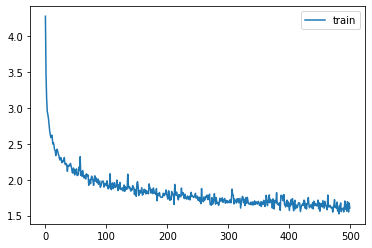

In [ ]:
#a, b = zip(*validations)
import matplotlib.pyplot as plt
plt.plot(all_losses, label='train')
#plt.plot(a, b, label='val')
plt.legend()
plt.show()

In [ ]:
# lowest loss achieved: 1.1849
# need to hit < 1 for decent performance
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  print(evaluate(start_strings[start], 200), '\n')

 lo
 loog Gandalf being spile me and his 
shall 
the great my a revining an one he laughters of 
the Ores to Arvainge of the brange to be seemed any tham the shall the Griders of the rassing to his forge b
None 

 he
 he said to now for a have seem was go lives. Now a while a seemeds stains of his with they wind and been it was still the night and like they was being far longs and the grown forget silen of 
fell th
None 

 I 
 I sas would of when a was every from the red shire. Pippin to field to him hand. If long seemed it him, and a fear of the hope the 
triend his that while the pitched have seemed the shall light long w
None 

 ra
 ran the 
would the road on his horse fillow. I fating and was a was a come as it will of the same them, that he will the tirm. 

Gandring any 
to seem. And hy 
lass for the rassone. Me not side to the
None 

 lo
 long. It would stirning of the for the pring. 

'What have the redouse the plane the rexiled the woods, and the shall for it he said Men for we

---

## Part 6: Generate output on a different dataset

---

**TODO:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)

**DONE:**
* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)


In [80]:
file = unidecode.unidecode(open('./text_files/alma.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 466656


In [81]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

ther they were overtaken by Antipus we knew not, but I said unto my men: Behold, we know not but they have halted for the purpose that we should come against them, that they might catch us in their sna


In [85]:
import time
n_epochs = 5000
print_every = 600
plot_every = 10
hidden_size = 200
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
#print('decoder_hidden: ')
 
start = time.time()
all_losses = []
loss_avg = 0

In [86]:
# n_epochs = 2000
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[235.3774597644806 (600 12%) 1.9241]
Whe deartion all seep the land to the Lamanites, and by the land of beerating and also the borle to t
None 

[468.800372838974 (1200 24%) 0.9799]
Wher had been became among the land of Moroni were said the Lold bethrents of the men of his brithers
None 

[702.4737682342529 (1800 36%) 1.1555]
Wher bethren which they were had anto the Nephites and thou hand of Amulek and his brethren unto the 
None 

[935.723762512207 (2400 48%) 1.2376]
Whes people to the earth, if the Lamanites and their commanded the confulation, and they were sealed 
None 

[1168.2617464065552 (3000 60%) 1.0519]
Whill know the sin of the wilderness, and those whom all the spirit of the land of Amulek to destruct
None 

[1400.7751903533936 (3600 72%) 0.7921]
Whill do not deent unto me down to be brethren, and they say them, and the day of the borth of the re
None 

[1634.09024477005 (4200 84%) 1.1087]
What astentions of the farom of the land.

 And thus we have for the south of the 

In [89]:
string_list = ['An', 'B', 'Th', 'F', 'At', 'Be', 'K', 'W', 'Z', 'Su', 'Tr', 'M', 'N', 'O', 'P']
for i in range(1, 16):
  prime_str = string_list[i-1]
  generated_sentence = evaluate(prime_str, 200) 
  print('{} ({}): {}'.format(i, prime_str, generated_sentence))

1 (An): And they said unto the men of the hearts of the land of Zarahemnances, and they brethren, and they had spoken unto them who were the word of Ammon and also the land of Zarahemla, to the church.

 And t
2 (B): B lek with attent therefore the people of Nephi.

 And they was a time get them that they might slay in the true of his men therefore they did came to pass that this things that they are no more who we
3 (Th): The sacred out of the war and therefore, now, the Lamanites can our manner of the judges of the judges.

 And now behold, they did not that they shall not on the church, and with the judges, and are no
4 (F): Fore--

 And now it came to pass that the for they went the wilderness of their fathers and strangence.

 And thus they are not the state were with the band of the servants of the Lamanites, and also s
5 (At): Ath the church, by the judges over the city of Manous, and his people of the take antance of their prisoners, and our hand into the same which had receive

It seems to me that the model does will given a starting string of something that it had seen before. This is evident by #6. It begins with "Behold" which I am sure occurs often in the text. However, I don't think that it can generalize very well. For example, there are many cases where it just prints out the letter that it's not used to seeing, and then will generate text unrelated.